# **Homework 2 - Classification**
若有任何问题，欢迎来信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

Binary classification is one of the most fundamental problem in machine learning. In this tutorial, you are going to build linear binary classifiers to predict whether the income of an indivisual exceeds 50,000 or not. We presented a discriminative and a generative approaches, the logistic regression(LR) and the linear discriminant anaysis(LDA). You are encouraged to compare the differences between the two, or explore more methodologies. Although you can finish this tutorial by simpliy copying and pasting the codes, we strongly recommend you to understand the mathematical formulation first to get more insight into the two algorithms. Please find [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) and [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf) for more detailed information about the two algorithms.

二元分类是机器学习中最基础的问题之一，在这份教学中，你将学会如何实作一个线性二元分类器，来根据人们的个人资料，判断其年收入是否高于 50,000 美元。我们将以两种方法: logistic regression 与 generative model，来达成以上目的，你可以尝试了解、分析两者的设计理念及差别。针对这两个算法的理论基础，可以参考李宏毅老师的教学投影片 [logistic regression](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) 与 [generative model](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)。

若有任何问题，欢迎来信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# Dataset

This dataset is obtained by removing unnecessary attributes and balancing the ratio between positively and negatively labeled data in the [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)), which can be found in [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php). Only preprocessed and one-hot encoded data (i.e. *X_train*,  *Y_train* and *X_test*) will be used in this tutorial. Raw data (i.e. *train.csv* and *test.csv*) are provided to you in case you are interested in it.

这个数据集是由 [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php) 的 [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)) 经过一些处理而得来。为了方便训练，我们移除了一些不必要的信息，并且稍微平衡了正负两种标记的比例。事实上在训练过程中，只有 X_train、Y_train 和 X_test 这三个经过处理的档案会被使用到，train.csv 和 test.csv 这两个原始资料文件则可以提供你一些额外的信息。

# Logistic Regression

In this section we will introduce logistic regression first. We only present how to implement it here, while mathematical formulation and analysis will be omitted. You can find more theoretical detail in [Prof. Lee's lecture](https://www.youtube.com/watch?v=hSXFuypLukA).

首先我们会实作 logistic regression，针对理论细节说明请参考[李宏毅老师的教学影片](https://www.youtube.com/watch?v=hSXFuypLukA)

### Preparing Data

Load and normalize data, and then split training data into training set and development set.

下载数据，并且对每个属性做正规化，处理过后再将其切分为训练集与发展集。

In [5]:
import numpy as np

np.random.seed(0)
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

# Parse csv files to numpy array

with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
    # 第一行是feature的名称，所以先执行next(f)跳过第一行的内容；第一个dimension是id，feature[1:]从第二个dimension开始读取
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
    # 读取第二列的结果
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

print('X_train :\n',X_train,X_train.shape,'\n')
print('Y_train :\n',Y_train,Y_train.shape,'\n')
print('X_test :\n',X_test,X_test.shape)

X_train :
 [[33.  1.  0. ... 52.  0.  1.]
 [63.  1.  0. ... 52.  0.  1.]
 [71.  0.  0. ...  0.  0.  1.]
 ...
 [16.  0.  0. ...  8.  1.  0.]
 [48.  1.  0. ... 52.  0.  1.]
 [48.  0.  0. ...  0.  0.  1.]] (54256, 510) 

Y_train :
 [1. 0. 0. ... 0. 0. 0.] (54256,) 

X_test :
 [[37.  1.  0. ... 52.  0.  1.]
 [48.  1.  0. ... 52.  0.  1.]
 [68.  0.  0. ...  0.  1.  0.]
 ...
 [38.  1.  0. ... 52.  0.  1.]
 [17.  0.  0. ... 40.  1.  0.]
 [22.  0.  0. ... 25.  1.  0.]] (27622, 510)


In [6]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    # 如果没有指定列，那就穷举所有列，这里np.arange类似于range函数，只不过np.arange创造的对象是array类型
    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    # train=True: for training data; train=False: for testing data，只计算training data的mean和std
    if train:
        # axis=0，对指定列求mean，注意np.mean返回的是一个列向量，因此需要用reshape(1,-1)转化成行向量
        X_mean = np.mean(X[:, specified_column] ,axis=0).reshape(1, -1)
        # axis=0，对指定列求std
        X_std  = np.std(X[:, specified_column], axis=0).reshape(1, -1)

    # 对指定列进行normalize，注意相减的两个向量行数不同但列数相同，相当于前者的每一行都减去x_mean这个行向量，除法同理
    # n维矩阵减1维矩阵，会将n维矩阵的每一个维度都减去该一维矩阵
    # 分母加一个很小很小的数是为了避免标准差为0
    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))

    #return x,y of training set and validation set  
    # 如果返回值为Y[:train_size, :]的话会报错，因为Y是一维array
    return X[:train_size , : ], Y[:train_size ], X[train_size: , :], Y[train_size: ]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size),"X_train",X_train.shape,"Y_train",Y_train.shape)
print('Size of development set: {}'.format(dev_size),"X_dev",X_dev.shape,"Y_dev",Y_dev.shape)
print('Size of testing set: {}'.format(test_size),"X_test",X_test.shape)
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830 X_train (48830, 510) Y_train (48830,)
Size of development set: 5426 X_dev (5426, 510) Y_dev (5426,)
Size of testing set: 27622 X_test (27622, 510)
Dimension of data: 510



### Some Useful Functions

Some functions that will be repeatedly used when iteratively updating the parameters.

这几个函数可能会在训练循环中被重复使用到。

In [7]:
dev_size = X_dev.shape[0]
# np.dot()的作用主要体现在两个1-D向量相乘和一个N-D矩阵和一个1-D向量相乘的情景下：
# 两个1-D向量A与B相乘(A、B元素数量必须相等)：等价于A、B对应元素相乘并累计求和，最终得到一个常量积；注意A*B和np.dot(A,B)的区别，前者是A、B对应元素相乘，每次相乘的积都作为新的1-D向量的一个元素，而不是把这些积累加为一个常量
# 一个N-D矩阵A和一个1-D向量B相乘(A的每一行元素数量必须与B的元素数量相等)：等价于把这个N-D矩阵A拆成N个1-D向量，它们分别与B做1-D矩阵的相乘，得到的积作为结果的一个元素，总共有N个积，最终的结果就是由这N个积组成的1-D向量
# np.dot()在w*x上的应用可以减少转置，在其他方面也有比较便利的应用
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    # 打乱原本的次序
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    # np.clip(a, a_min, a_max)将数组a限制在a_min和a_max之间，超出范围的值将被赋以边界值
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    # return _sigmoid(np.dot(x, w) + b)也可以，np.dot特别适合用来计算x*w，无需转置，直接就是N维x的每一行与一维w相乘得到的结果汇总成一个一维的y 
    # dot: 
    # 1.向量其实是一维的矩阵，两个向量进行内积运算 
    # 2.x为 m×n 阶矩阵，y为 n×p 阶矩阵，则相乘的结果 result 为 m×p 阶矩阵。 
    # 3.矩阵x为m×n阶，向量y为n阶向量，则矩阵x和向量y可以进行乘法运算，结果为m阶向量。进行运算时，会首先将后面一项进行自动转置操作，之后再进行乘法运算。
    # matmul:
    # 如果第一个参数或者第二个参数是1 维的，matmul会提升该参数为矩阵（根据另一个参数维数，给该参数增加一个为1的维数）。矩阵相乘之后会将为1的维数去掉。
    # 如果某一个参数是N(N>2) )维的，该参数被理解为一些矩阵(参数的最后两个维数为矩阵维数)的stack，而且计算时会相应的广播。
    return _sigmoid(np.matmul(X, w) + b)


def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    # 利用round函数的四舍五入功能把概率转化成0或1
    return np.round(_f(X, w, b)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    # 预测值和标签值相减，取绝对值后再求平均，相当于预测错误的个数(差为1)/总个数，即错误率，1-错误率即正确率
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

### Functions about gradient and loss

Please refers to [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)(p.12) for the formula of gradient and loss computation.

请参考[李宏毅老师上课投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)第 12 页的梯度及损失函数计算公式。

In [8]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    # cross_entropy = -Σ(y_head*ln(y)+(1-y_head)*ln(1-y))
    # 注意，这里的np.dot可以直接计算两个一位矩阵的积(前提是元素个数一致)，无需转置；np.log()等价于ln()
    # 因此这里的矩阵积实际上已经做了Σ的工作，左边的np.dot计算的是Σ(y_head*ln(y)，右边的np.dot计算的是Σ(1-y_head)*ln(1-y))
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    # w: weight vector, shape = [data_dimension, ]
    # b: bias, scalar
    pred_error = Y_label - y_pred
    # pred_error: [data_size, ]
    # X.T: [data_dimension, data_size ]
    # numpy广播机制， 每一行（i_of_size行),都乘相应的 error i_of_size     
    w_grad = -np.sum(pred_error * X.T, axis=1)  
    # axis=1, 每一行的元素相加, 将矩阵压缩为一列  
    # 也可以是w_grad = -np.dot(X.T, pred_error) 
    # gradient:   wi +=   -lr * Σ (y_head^n - x_pred_n)  * x_i_n   n: 第n维   i: 第i行 第i个component
    # gradient:   b  +=   -lr * Σ (y_head^n - x_pred_n)            n: 第n维   i: 第i行 第i个component
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad



### Training

Everything is prepared, let's start training! 

Mini-batch gradient descent is used here, in which training data are split into several mini-batches and each batch is fed into the model sequentially for losses and gradients computation. Weights and bias are updated on a mini-batch basis.

Once we have gone through the whole training set,  the data have to be re-shuffled and mini-batch gradient desent has to be run on it again. We repeat such process until max number of iterations is reached.

我们使用小批次梯度下降法来训练。训练资料被分为许多小批次，针对每一个小批次，我们分别计算其梯度以及损失，并根据该批次来更新模型的参数。当一次循环完成，也就是整个训练集的所有小批次都被使用过一次以后，我们将所有训练数据打散并且重新分成新的小批次，进行下一个循环，直到事先设定的循环数量达成为止。

In [10]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 10
batch_size = 8
learning_rate = 0.2

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
            
    # Compute loss and accuracy of training set and development set
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    # predict函数将Probability取round，只剩下0和1
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)
    # Probability用来计算cross_entropy，不能用round后的值，否则会出现ln(0)的错误
     # average cross_entropy
    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.27060297037387315
Development loss: 0.2974835612266556
Training accuracy: 0.8847020274421462
Development accuracy: 0.8741245853298931
[0.8753839852549662, 0.8786811386442761, 0.881261519557649, 0.8826336268687283, 0.8824902723735408, 0.882817939791112, 0.8832684824902723, 0.8836575875486381, 0.8836166291214418, 0.8847020274421462]


### Plotting Loss and accuracy curve

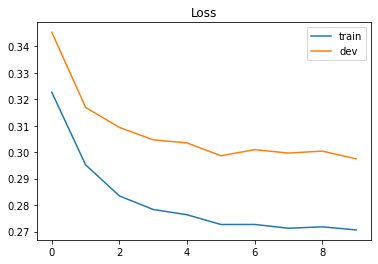

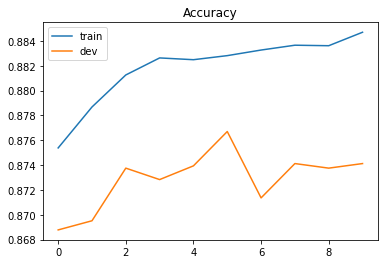

In [11]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.show()

# np.save('weight_adagrad_gd.npy', w)
# np.save('bias_adagrad_gd.npy', b)

###Predicting testing labels

Predictions are saved to *output_logistic.csv*.

预测测试集的数据标签并且存在 *output_logistic.csv* 中。

In [12]:
# Predict testing labels
# w = np.load('weight_adagrad.npy')
# b = np.load('bias_adagrad.npy')
predictions = _predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Georgia -1.8673204532957646
 Other Rel <18 never marr child of subfamily RP -1.4592218302179771
 Other Rel <18 never married RP of subfamily -1.3997372175214722
 Unemployed full-time 1.1650014511146882
 Other Rel <18 ever marr RP of subfamily -1.152975918931713
 Child 18+ ever marr RP of subfamily -0.9771172429861952
 1 0.8276879900964124
 2 -0.7707457269126505
 High school graduate -0.7688912490463709
dividends from stocks -0.7276294720510403


# Porbabilistic generative model

In this section we will discuss a generative approach to binary classification. Again, we will not go through the formulation detailedly. Please find [Prof. Lee's lecture](https://www.youtube.com/watch?v=fZAZUYEeIMg) if you are interested in it.

接者我们将实作基于 generative model 的二元分类器，理论细节请参考[李宏毅老师的教学影片](https://www.youtube.com/watch?v=fZAZUYEeIMg)。

### Preparing Data

Training and testing data is loaded and normalized as in logistic regression. However, since LDA is a deterministic algorithm, there is no need to build a development set.

训练集与测试集的处理方法跟 logistic regression 一模一样，然而因为 generative model 有可解析的最佳解，因此不必使用到 development set。

In [13]:
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

### Mean and Covariance

In generative model, in-class mean and covariance are needed.

在 generative model 中，我们需要分别计算两个类别内的数据平均与共变异。

In [14]:
# Compute in-class mean
# zip的作用是把x和y打包成一个元组，然后根据y的值就能够挑选出所有y=0的x和y=1的x
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

# 对两组x重新求mean
mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)  

# Compute in-class covariance
# 计算in-class covariance
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.
# 对in-class covariance进行加权平均，并用来共享
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

### Computing weights and bias

Directly compute weights and bias from in-class mean and shared variance. [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)(p.33) gives a concise explanation.

权重矩阵与偏差向量可以直接被计算出来，算法可以参考[李宏毅老师教学投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)第 33 页。

In [15]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# Compute accuracy on training set
Y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.8721431731052787


### Predicting testing labels

Predictions are saved to *output_generative.csv*.

预测测试集的数据标签并且存在 *output_generative.csv* 中。

In [16]:
# Predict testing labels
predictions = 1 - _predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])


 46 -6.6875
 Adm support including clerical 5.765625
 MSA to nonMSA -5.484375
 45 4.62109375
 Professional specialty -4.6015625
 Other Rel 18+ never marr RP of subfamily 4.4375
 Manufacturing-durable goods -4.3515625
 29 4.328125
 Different state same division 3.9921875
 Child <18 ever marr not in subfamily 3.5625
